#### Импорт библиотек

In [1]:
!pip install pandarallel

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pandarallel import pandarallel

pandarallel.initialize()

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


#### Загрузка и чистка данных от выбросов

In [2]:
MONTH = 9

assert MONTH in {9, 10, 11}

In [ ]:
!gdown --id 13Qm6ztAmVyBHvo_mch6gk-2VYKUHeRuu
!tar -xf inno_stats.tar.gz

Downloading...
From: https://drive.google.com/uc?id=13Qm6ztAmVyBHvo_mch6gk-2VYKUHeRuu
To: /content/inno_stats.tar.gz
1.91GB [00:20, 94.6MB/s]


In [3]:
bad_ids = pd.read_csv('bad_ids.csv')
bad_ids = set(bad_ids['id_card'])

In [4]:
filename = '09_groups.csv'
if MONTH != 9:
    filename = f'{MONTH}_groups.csv'

cleaned_df = pd.read_csv(filename)
cleaned_df = cleaned_df[~cleaned_df['id_card'].isin(bad_ids)]
cleaned_df.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
0,2020-09-01 17:01:25,1283228,0.0,1538855,52,271,1.0,108.00,0,10004
1,2020-09-01 17:35:36,8873113,0.0,267307,52,271,1.0,108.00,0,10004
2,2020-09-01 19:19:21,12712899,0.0,610220,52,271,1.0,107.95,0,10004
3,2020-09-01 21:53:34,21535283,0.0,441497,52,271,1.0,108.00,0,10004
4,2020-09-01 18:42:31,642341,0.0,1065358,61,97,2.0,88.00,0,10091


#### **Задание 1**: доказать, что покупка товаров со скидкой зависит от средней суммы заказа

In [ ]:
receipts_avg_sum = cleaned_df.groupby('id_doc')['sum'].mean()
receipts_green_cnt = cleaned_df.groupby('id_doc')['is_green'].sum()
green_buyers = receipts_green_cnt.index[receipts_green_cnt.to_numpy().nonzero()]
nongreen_buyers = list(set(receipts_green_cnt.index).difference(green_buyers))

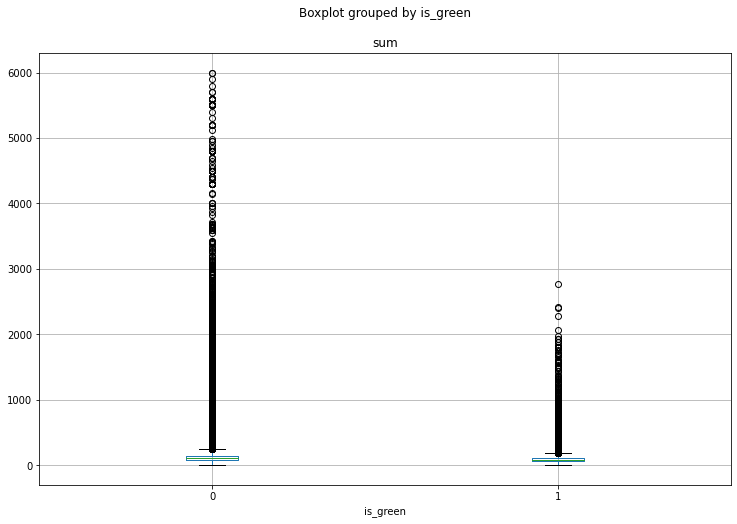

In [ ]:
green_nongreen = receipts_avg_sum.to_frame()
green_nongreen['is_green'] = 0
green_nongreen.loc[green_buyers, 'is_green'] = 1

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
(
    green_nongreen[green_nongreen['sum'] <= 6000]
    .boxplot(column='sum', by='is_green', figsize=(12, 8))
);

In [ ]:
stats.ttest_ind(
    receipts_avg_sum[green_buyers], 
    receipts_avg_sum[nongreen_buyers]
)

Ttest_indResult(statistic=-379.1254533395915, pvalue=0.0)

In [ ]:
stats.mannwhitneyu(
    receipts_avg_sum[green_buyers],
    receipts_avg_sum[nongreen_buyers]
)

MannwhitneyuResult(statistic=2149489664201.5, pvalue=0.0)

Стало быть нулевая гипотеза о том, что разницы нет, может быть отвергнута.

#### **Задание 2**: доказать, что частота покупок растет в дни получения заработных плат (1-6, 20-26 дни в каждом месяце)

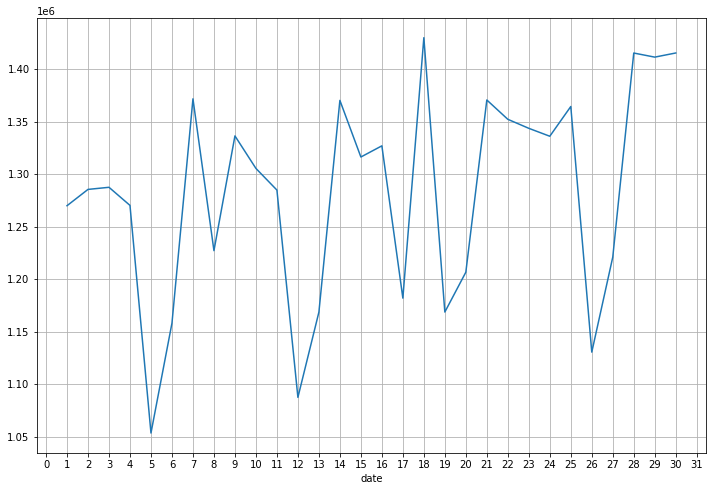

In [ ]:
cleaned_df.index = pd.to_datetime(
    cleaned_df['date'], 
    format='%Y-%m-%d %H:%M:%S'
)

num_of_buyings = cleaned_df.groupby(cleaned_df.index.day)['id_order'].count()

plt.figure(figsize=(12, 8))
plt.locator_params(axis='x', nbins=50)
num_of_buyings.plot()
plt.title('Сентябрь')
plt.grid()

На отрезке в первые 3 дня видно, как растет количество покупок, также видно, что на отрезке 21-25, есть какое-то подобие возвышенного плато.

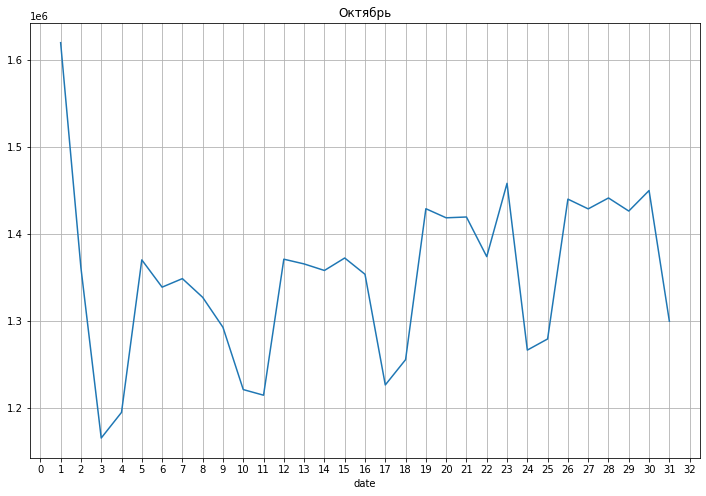

In [ ]:
cleaned_df.index = pd.to_datetime(
    cleaned_df['date'], 
    format='%Y-%m-%d %H:%M:%S'
)

num_of_buyings = cleaned_df.groupby(cleaned_df.index.day)['id_order'].count()

plt.figure(figsize=(12, 8))
plt.locator_params(axis='x', nbins=50)
num_of_buyings.plot()
plt.title('Октябрь')
plt.grid()

Тут наблюдается рост числа покупок на отрезках 3-5 и 24-26, так что гипотеза снова подтверждается.

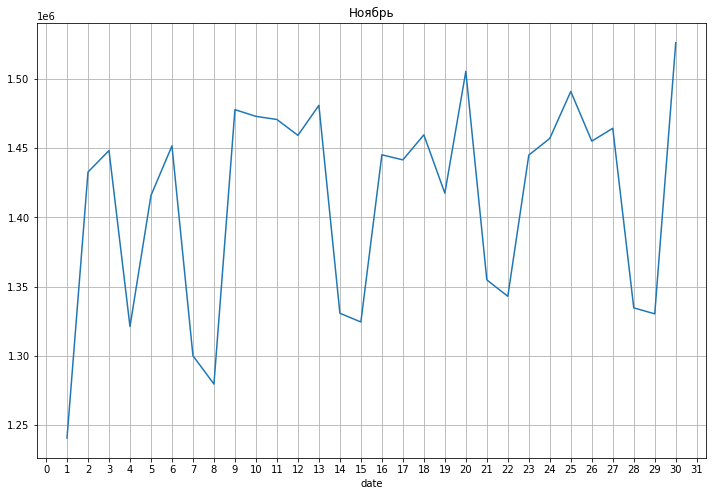

In [ ]:
cleaned_df.index = pd.to_datetime(
    cleaned_df['date'], 
    format='%Y-%m-%d %H:%M:%S'
)

num_of_buyings = cleaned_df.groupby(cleaned_df.index.day)['id_order'].count()

plt.figure(figsize=(12, 8))
plt.locator_params(axis='x', nbins=50)
num_of_buyings.plot()
plt.title('Ноябрь')
plt.grid()

Здесь ситуация, в принципе, похожая, как и на предыдущих месяцах, так что можно сделать вывод о том, что действительно в дни выдачи заработных плат количество покупок растет.

#### **Задание 3**: поиск когорт

Частые покупатели - ежедневно, еженедельно, месячно

In [ ]:
def calc_diffs(df, freq='D'):
    dates = set(df['date'])
    dates = sorted(dates)
    diffs = np.diff(dates)
    freq2func = {
        'D': lambda x: x.days,
        'W': lambda x: x.days / 7,
    }
    func = freq2func[freq]
    return [func(diff) for diff in diffs]


cnt_orders = cleaned_df.groupby('id_card')['id_order'].count()
freq_orders = (
    cleaned_df[cleaned_df['id_card'].isin(cnt_orders[cnt_orders > 20].index)]
)
diffs = freq_orders.groupby('id_card').apply(calc_diffs)
diffs = diffs[diffs.apply(len) > 4]
delta = diffs.apply(lambda arr: len([e for e in arr if e == 1]))

plt.hist(delta)
plt.xlabel('Number of "every day" purchases')
plt.ylabel('Count');

Средняя сумма покупки - клиенты, которые тратят обычно одну и ту же сумму

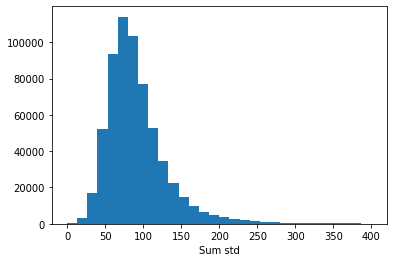

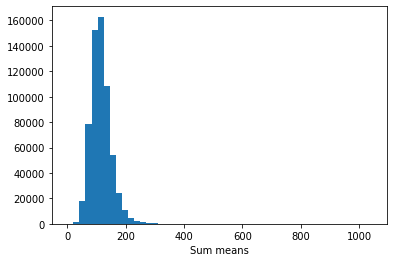

In [ ]:
cust_stds = cleaned_df.groupby('id_card')['sum'].std()
cust_means = cleaned_df.groupby('id_card')['sum'].mean()
cust_cnt = cleaned_df.groupby('id_card')['sum'].count()

is_cust_freq = cust_cnt > 15
freq_cust_means = cust_means[is_cust_freq.index[np.where(is_cust_freq)[0]]]
freq_cust_stds = cust_stds[is_cust_freq.index[np.where(is_cust_freq)[0]]]
freq_cust_stds = freq_cust_stds[freq_cust_stds < 400]

plt.xlabel('Sum std')
plt.hist(freq_cust_stds, bins=30);
plt.show()

plt.xlabel('Sum means')
plt.hist(freq_cust_means, bins=50);
plt.show()

Типичная карта - клиенты сгруппированные по типам продуктов

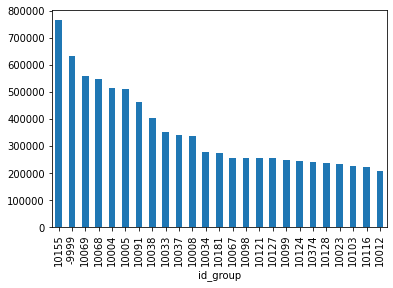

In [ ]:
group2amount_cards = (
    cleaned_df
    .groupby('id_group')['id_card'].unique()
    .apply(len)
)
group2amount_cards.sort_values(ascending=False)[:25].plot(kind='bar');